In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

import statsmodels.api as sm
import statsmodels.formula.api as smf

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE, nice_boxplot, nice_violinplot, mimic_r_boxplot


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
from data_loading import (load_annotated_6k_collection,
                          load_valid_isoform_clones,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped)

In [4]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [5]:
np.random.seed(2023)

## functions

In [6]:
def calculate_tau(df):
    array = df.values
    
    ## will return NaN as tau for every row that has any NaNs
    array_max = np.max(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nonan_taus = np.sum(tmp, axis=1) / (array.shape[1])
    
    ## will ignore NaNs and compute on the rest of the values
    array_max = np.nanmax(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nan_taus = np.nansum(tmp, axis=1) / np.count_nonzero(~np.isnan(array), axis=1)
    
    
    return nonan_taus, nan_taus, array_max

In [7]:
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

## variables

In [8]:
dn_cats_f = "../data/processed/DN_cats_Joung.tsv"

In [9]:
pal = {"ref": sns.color_palette("Set2")[0],
       "ref-v-ref": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray",
       "both": sns.color_palette("Set2")[3]}

## 1. import data

In [10]:
dn_cats = pd.read_table(dn_cats_f)
dn_cats["dn_cat"].fillna("NA", inplace=True)
dn_cats.dn_cat.value_counts()

NA        278
ref       246
DN         93
rewire     74
likely      2
Name: dn_cat, dtype: int64

In [11]:
tfs = load_annotated_6k_collection()

reading from cache


In [12]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [13]:
metadata_gtex_dummy = pd.read_table("../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

In [14]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


## 2. down-sample gtex using the same dummy metadata as fig 1

In [15]:
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

## 3. calculate expression ratios (copy-pasted from luke's code in expr_data.ipynb)

In [16]:
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [17]:
per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [18]:
df_gtex.loc[:,metadata_gtex_dummy.index].shape

(1376, 313)

In [19]:
df_gtex.shape

(1376, 2485)

In [20]:
per_gene_gtex_ds = ((2 ** df_gtex.loc[:,metadata_gtex_dummy.index] - 1)
                   .groupby(genes_gtex)
                   .transform('sum'))

f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

## 3. calculate tissue-specificity

this is currently across all individual samples for genes but not for isos

In [21]:
gene_dev_nonan_taus, gene_dev_nan_taus, gene_dev_array_max = calculate_tau(per_gene_dev.drop_duplicates())
gene_dev_nan_taus[0:5]

array([0.72426949, 0.79449918, 0.84426404, 0.87460237, 0.91855192])

In [22]:
gene_gtex_nonan_taus, gene_gtex_nan_taus, gene_gtex_array_max = calculate_tau(per_gene_gtex.drop_duplicates())
gene_gtex_nan_taus[0:5]

array([0.77681209, 0.94432032, 0.95815292, 0.93717632, 0.79040074])

In [23]:
gene_gtex_ds_nonan_taus, gene_gtex_ds_nan_taus, gene_gtex_ds_array_max = calculate_tau(per_gene_gtex_ds.drop_duplicates())
gene_gtex_ds_nan_taus[0:5]

array([0.7866663 , 0.90947223, 0.94015015, 0.74260678, 0.80111849])

In [24]:
gene_taus = pd.DataFrame()
gene_taus["UID"] = per_gene_dev.drop_duplicates().index
gene_taus["dev_tau"] = gene_dev_nan_taus
gene_taus["gtex_tau"] = gene_gtex_nan_taus
gene_taus["gtex_ds_tau"] = gene_gtex_ds_nan_taus
gene_taus["gene_name"] = gene_taus["UID"].str.split("|", expand=True)[0]
gene_taus.sample(5)

,UID,dev_tau,gtex_tau,gtex_ds_tau,gene_name
262,ZNF419|1/4|02H10 ZNF419-201,0.604219,0.933575,0.783106,ZNF419
13,DDIT3|1/2|05B05 DDIT3-204_DDIT3-205,0.992327,0.995127,0.973420,DDIT3
295,ZNF75A|1/2|11B06 ZNF75A-205_ZNF75A-210,0.782886,0.944171,0.854358,ZNF75A
307,ZSCAN32|1/5|05B06 ZSCAN32-203,0.788543,0.863190,0.743289,ZSCAN32
83,LHX9|1/3|06C10 LHX9-201,0.956154,0.985383,0.972817,LHX9


## 4. join with DN categories

In [25]:
indiv_cols = f_dev.columns
dev_ratios = f_dev.reset_index()

dev_ratios["clone_acc"] = dev_ratios["UID"].str.split(" ", expand=True)[0]
dev_ratios.head()

,UID,forebrain 04,forebrain 05,forebrain 07,forebrain 08,forebrain 09,forebrain 10,forebrain 11,forebrain 12,forebrain 13,...,testis 16,testis 18,testis 19,testis adolescent,testis adult,testis elderly,testis infant,testis toddler,testis young adult,clone_acc
0,AEBP2|2/3|05F03 nomatch,8.770825,5.460097,3.748771,3.188589,0.440583,3.743192,4.894554e+00,5.178928,12.198085,...,1.323679,4.141163,22.014329,1.928627,18.013990,0.000000,4.813526,2.366820,3.044304,AEBP2|2/3|05F03
1,AEBP2|3/3|05E07 nomatch,1.128610,0.492277,8.731672,0.803170,0.000000,0.000000,0.000000e+00,0.000000,0.440492,...,0.678523,0.000000,1.916075,0.000000,0.000000,0.000000,3.721128,0.542803,0.000000,AEBP2|3/3|05E07
2,ARNT2|1/6|08C12 ARNT2-201,94.168553,98.542376,96.466911,98.552748,87.660480,98.939268,9.904231e+01,96.300384,96.502246,...,97.224681,100.000000,100.000000,48.332268,56.638580,43.556409,96.666964,100.000000,58.799880,ARNT2|1/6|08C12
3,ARNT2|2/6|09E01 nomatch,3.216348,0.869466,3.533089,0.456195,0.000000,0.290142,2.459982e-01,1.376733,0.794998,...,0.000000,0.000000,0.000000,0.000000,1.729682,0.000000,0.150583,0.000000,0.174124,ARNT2|2/6|09E01
4,ARNT2|3/6|10D11 ARNT2-209,0.000000,0.000000,0.000000,0.000000,11.955511,0.000000,2.650723e-10,0.585737,0.000000,...,1.131732,0.000000,0.000000,46.973894,0.000000,36.444243,0.003060,0.000000,27.707265,ARNT2|3/6|10D11


In [26]:
indiv_cols = f_gtex.columns
gtex_ratios = f_gtex.reset_index()

gtex_ratios["clone_acc"] = gtex_ratios["UID"].str.split(" ", expand=True)[0]

In [27]:
indiv_cols = f_gtex_downsample.columns
gtex_ds_ratios = f_gtex_downsample.reset_index()

gtex_ds_ratios["clone_acc"] = gtex_ds_ratios["UID"].str.split(" ", expand=True)[0]

In [28]:
dev_ratios = dev_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id").drop_duplicates()
gtex_ratios = gtex_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id").drop_duplicates()
gtex_ds_ratios = gtex_ds_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id").drop_duplicates()
print(len(dev_ratios))
print(len(gtex_ratios))
print(len(gtex_ds_ratios))

692
692
692


## 5. calculate co-expression

In [29]:
# def count_coex(row, thresh):
#     tot = 0
#     for col in indiv_cols:
#         ref_val = row["%s_ref" % col]
#         alt_val = row["%s_alt" % col]
#         if ref_val > thresh and alt_val > thresh:
#             tot += 1
#     return tot

In [30]:
# ratios_ref = ratios[ratios["dn_cat"] == "ref"]
# ratios_alt = ratios[ratios["dn_cat"] != "ref"]

# ratios_v = ratios_ref.merge(ratios_alt, on="gene_name", suffixes=("_ref", "_alt"))
# ratios_v["num_coex"] = ratios_v.apply(count_coex, thresh=0.1, axis=1)
# ratios_v["num_coex"].fillna(0, inplace=True)
# ratios_v.sample(5)

In [31]:
# # do the null test: randomly sample 2 refs 100 times and do the same thing
# null = pd.DataFrame()
# for i in range(100):
#     ref1 = ratios_ref.sample()
#     ref2 = ratios_ref.sample()
    
#     ref1["tmp_gene"] = "tmp_gene"
#     ref2["tmp_gene"] = "tmp_gene"
    
#     mrg = ref1.merge(ref2, on="tmp_gene", suffixes=("_ref", "_alt"))
#     mrg["gene_name"] = mrg["gene_name_ref"] + "-v-" + mrg["gene_name_alt"]
#     mrg["dn_cat_alt"] = "ref-v-ref"
#     mrg["num_coex"] = mrg.apply(count_coex, thresh=0.1, axis=1)
#     null = null.append(mrg)

# null.sample(5)

In [32]:
# ratios_coex = ratios_v[["gene_name", "tf1p0_id_ref", 
#                         "tf1p0_id_alt", "dn_cat_alt", 
#                         "num_coex", "neglog_diff_pval_ref", 
#                         "neglog_diff_pval_alt"]].append(null[["gene_name", "tf1p0_id_ref", 
#                                                               "tf1p0_id_alt", "dn_cat_alt", "num_coex",
#                                                               "neglog_diff_pval_ref", "neglog_diff_pval_alt"]])
# ratios_coex.dn_cat_alt.value_counts()

## 6. make some plots

In [33]:
dn_cats = dn_cats.merge(gene_taus, on="gene_name").drop_duplicates()
print(len(dn_cats))
dn_cats.head()

693


,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len,UID,dev_tau,gtex_tau,gtex_ds_tau
0,ZBTB18,C2H2 ZF,ZBTB18|1/2|04E08,False,True,ref,ref,Genewiz,TFORF2495,ZBTB18,...,TFORF2495-ZBTB18,0.172521,0.002115,0.168074,-0.004946,531.0,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.951368
1,ZBTB18,C2H2 ZF,ZBTB18|2/2|12E05,False,False,rewire,alt,Genewiz,TFORF2494,ZBTB18,...,TFORF2494-ZBTB18,0.006114,0.003615,0.244046,-0.003313,522.0,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.951368
2,PRRX1,Homeodomain,PRRX1|2/3|09F06,False,True,ref,ref,Genewiz,TFORF1217,PRRX1,...,TFORF1217-PRRX1,0.365286,0.000400,0.000021,-0.009730,245.0,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.845530
3,PRRX1,Homeodomain,PRRX1|1/3|09C07,False,False,NA,alt,Genewiz,TFORF1218,PRRX1,...,TFORF1218-PRRX1,0.006905,0.002594,0.000440,-0.001672,217.0,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.845530
4,PRRX1,Homeodomain,PRRX1|3/3|09H08,False,False,rewire,alt,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.845530


In [34]:
ref_expr = dn_cats.groupby(["gene_name", "family", "dn_cat", "dev_tau",
                            "gtex_tau", "gtex_ds_tau"])["tf1p0_id"].agg("count").reset_index()
ref_expr = ref_expr.pivot(index="gene_name",
                          columns="dn_cat", values="tf1p0_id")
ref_expr.fillna(0, inplace=True)

In [35]:
def categorize_gene(row):
    if row.DN > 0 and row.rewire > 0:
        return "both"
    elif row.DN > 0:
        return "DN"
    elif row.rewire > 0:
        return "rewire"
    elif row.NA > 0:
        return "NA"
    
ref_expr["gene_cat"] = ref_expr.apply(categorize_gene, axis=1)
ref_expr.reset_index(inplace=True)
ref_expr = ref_expr.merge(dn_cats[["gene_name", "family", "dev_tau", "gtex_tau", "gtex_ds_tau"]],
                          on="gene_name").drop_duplicates()
print(len(ref_expr))
ref_expr.sample(5)

246


,gene_name,DN,NA,likely,ref,rewire,gene_cat,family,dev_tau,gtex_tau,gtex_ds_tau
125,GLIS2,0.0,1.0,0.0,1.0,0.0,NA,C2H2 ZF,0.891479,0.926703,0.926548
30,CXXC1,0.0,1.0,0.0,1.0,0.0,NA,CxxC,0.683629,0.728421,0.683891
17,ATF3,0.0,1.0,0.0,1.0,0.0,NA,bZIP,0.974409,0.984790,0.972288
0,AEBP2,0.0,1.0,0.0,1.0,0.0,NA,C2H2 ZF,0.724269,0.776812,0.786666
312,PPARG,0.0,0.0,2.0,1.0,1.0,rewire,Nuclear receptor,0.982176,0.997532,0.985709


0.014467299638211742
0.7549533746276446
0.009541637032159267
0.04493706581280249
35
46
17
148


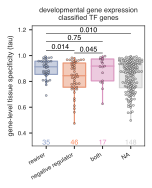

In [36]:
nice_boxplot(ref_expr, "dev_tau", "gene_cat", pal, ["rewire", "DN", "both", "NA"], 
            [1.04, 1.11, 1.17, 1.02], 0.35, "", ["rewirer", "negative regulator", "both", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.3, 1.23), 
            "developmental gene expression\nclassified TF genes", 
            "../figures/DN_DevTau_Gene_Boxplot.pdf")

0.054721422639715245
0.7998098714316051
0.12662906424741782
0.2361897000525347
35
46
17
148


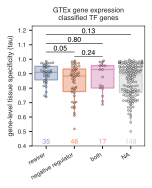

In [39]:
nice_boxplot(ref_expr, "gtex_ds_tau", "gene_cat", pal, ["rewire", "DN", "both", "NA"], 
            [1.05, 1.11, 1.17, 1.02], 0.45, "", ["rewirer", "negative regulator", "both", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.4, 1.23), 
            "GTEx gene expression\nclassified TF genes", 
            "../figures/DN_GTExDsTau_Gene_Boxplot.pdf")

0.015655700388142863
0.36954301870329664
0.06844931592246827
0.41625453109554067
35
46
17
148


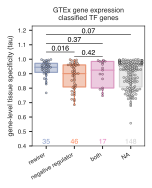

In [40]:
nice_boxplot(ref_expr, "gtex_tau", "gene_cat", pal, ["rewire", "DN", "both", "NA"], 
            [1.05, 1.11, 1.17, 1.02], 0.45, "", ["rewirer", "negative regulator", "both", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.4, 1.23), 
            "GTEx gene expression\nclassified TF genes", 
            "../figures/DN_GTExTau_Gene_Boxplot.pdf")

In [41]:
def developmental_tissue_expression_plot(gene_name, figsize, ylim, means, cols, fig_suffix):
    locs = [x for x in list(means.index) if x.split("|")[0] == gene_name]
    n_isos = len(means.loc[locs])
    palette = sns.color_palette("Spectral", as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[locs, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[locs, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_ylabel('log2(tpm + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../figures/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

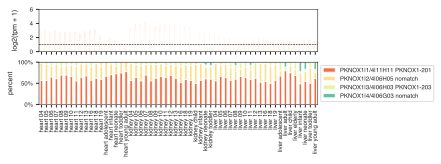

In [42]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
notestis_cols = [x for x in notestis_cols if "ovary" not in x]
notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("PKNOX1", (5, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis")

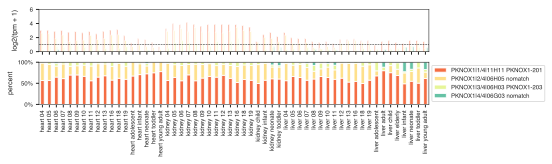

In [45]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
notestis_cols = [x for x in notestis_cols if "ovary" not in x]
notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("PKNOX1", (7, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis_large")

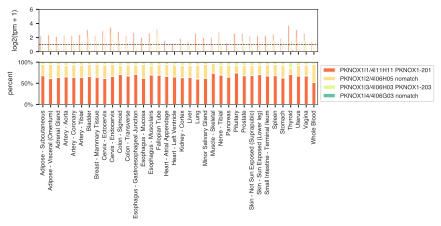

In [44]:
notestis_cols = [x for x in means_gtex.columns if "Testis" not in x]
notestis_cols = [x for x in notestis_cols if "_gtex" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
notestis_cols = [x for x in notestis_cols if "Ovary" not in x]
notestis_cols = [x for x in notestis_cols if "Brain" not in x]
developmental_tissue_expression_plot("PKNOX1", (5, 1.75), (0, 6), means_gtex, notestis_cols, 
                                     "means_gtex_notestis")

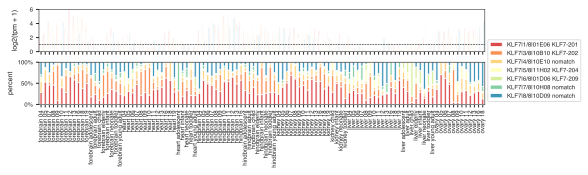

In [47]:
notestis_cols = [x for x in means_dev.columns if "testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
# notestis_cols = [x for x in notestis_cols if "ovary" not in x]
# notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("KLF7", (8, 1.75), (0, 6), means_dev, notestis_cols, 
                                     "means_dev_notestis_large")

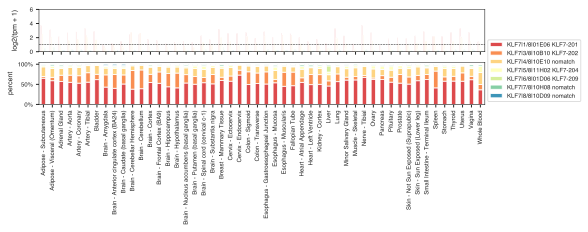

In [49]:
notestis_cols = [x for x in means_gtex.columns if "Testis" not in x]
notestis_cols = [x for x in notestis_cols if "_dev" not in x]
notestis_cols = [x for x in notestis_cols if "max_" not in x]
# notestis_cols = [x for x in notestis_cols if "ovary" not in x]
# notestis_cols = [x for x in notestis_cols if "brain" not in x]
developmental_tissue_expression_plot("KLF7", (8, 1.75), (0, 6), means_gtex, notestis_cols, 
                                     "means_gtex_notestis_large")

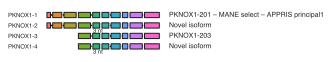

In [50]:
fig, ax = plt.subplots(figsize=(4.5, 0.75))

tfs["PKNOX1"].exon_diagram(ax=ax)

fig.savefig("../figures/PKNOX1_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

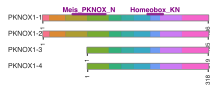

In [51]:
fig, ax = plt.subplots(figsize=(3, 1))

tfs["PKNOX1"].protein_diagram(only_cloned_isoforms=False, draw_legend=False, ax=ax)

fig.savefig("../figures/PKNOX1_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

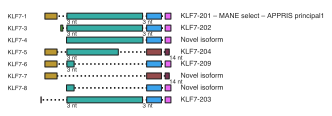

In [56]:
fig, ax = plt.subplots(figsize=(4.5, 1.5))

tfs["KLF7"].exon_diagram(ax=ax)

fig.savefig("../figures/KLF7_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

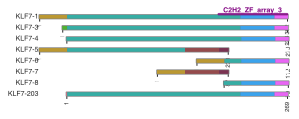

In [57]:
fig, ax = plt.subplots(figsize=(4.5, 1.5))

tfs["KLF7"].protein_diagram(only_cloned_isoforms=False, draw_legend=False, ax=ax)

fig.savefig("../figures/KLF7_protein_diagram.pdf", bbox_inches="tight", dpi="figure")